<a href="https://colab.research.google.com/github/meixinzhang/rigid-moving-objects/blob/main/rigid-moving-object.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some Title

Meixin Zhang, 

At the top, the notebook should have a clear title, your name,

### *Abstract*

a separate cell with a concise two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project. 


### Team Members and Contributions

This cell should contain an itemized list of all team members. Each item (bullet) should start with a name and detail this person's contributions. 

- Meixin: 


### Code Libraries

You should also have a separate cell titled code libraries acknowledging all external code libraries "essential" for your project. You should explain the importance of each such library for your project. 

If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory. 

If needed, for better organization and clarity of your project you can write your own code libraries that should be summarized in this section as well. The corresponding (.py) files should be included in mylibs subdirectory. For group projects, you can refer to your team's libraries in the earlier "contributions" section. At the bottom of your notebook, you should include a cell with two-three paragraphs summarizing the conclusions of your project.


In [1]:
# Packages
import numpy as np
import numpy.linalg as la
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
from skimage.transform import EssentialMatrixTransform
from skimage.color import rgb2gray

# TODO: REPLACE RANSAC WITH UFL
from skimage.measure import ransac

# Our Libraries 
from mylibs.structure_from_motion_lib import (
    get_matched_keyppoints, 
    matchedpoints_to_pairpoints, 
    camera_calib_nomalization,
    get_epipolar_lines,
    P_from_E,
    Afrom2pts,
    generate_X_from_A,
    get_proj_pts,
    #estimate_ufl,
)

## Implementation

Unsupervised detection and segmentation of (multiple) rigidly moving objects. 

You can detect multiple fundamental matrices while matching sparse features (Topics 6-7) and integrate these into loss functions for dense segmentation (topic 9). Essentially, this can be implemented as a combination of methods in HW3 and HW4. You can use any (pairs of) images for this project

Different parts of an image going through different kinds of movements (different essential/fundamental matrices)  - UFL

Use RANSAC/UFL for inlier matches multiple times, then find different fundamental matrices from that. Generate points from the surface based on the matrices. Ideally these should be on the same objects(A2)

Use the generated points (on the same reconstructed surfaces) as points that are ground truth, come up with the loss function (?) (A4)

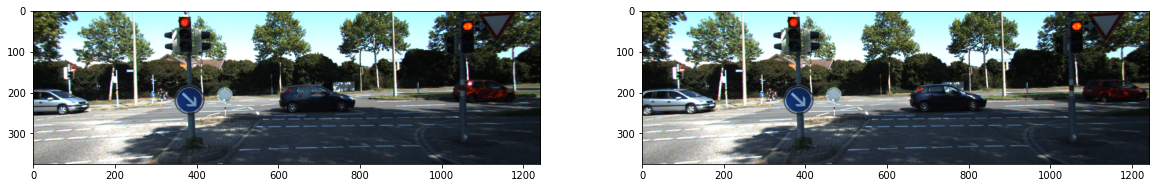

In [2]:
%matplotlib inline

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/car1_left.png")
imR = image.imread("images/car1_right.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# using K_02 from calibration.txt
K = 1.0e+02 * np.array([[9.597910,        0, 6.960217],
                        [       0, 9.569251, 2.241806],
                        [       0,        0,    0.010]])

plt.figure(0,figsize = (20, 8))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

## Structure from Motion Using UFL and Epipolar Geometry

#### Step 1: Feature Detection and Matching

Detect corners on the pictures and match using BRIEF descriptor.

the number of features in images 1 and 2 are   249 and   249
the number of matches is 199


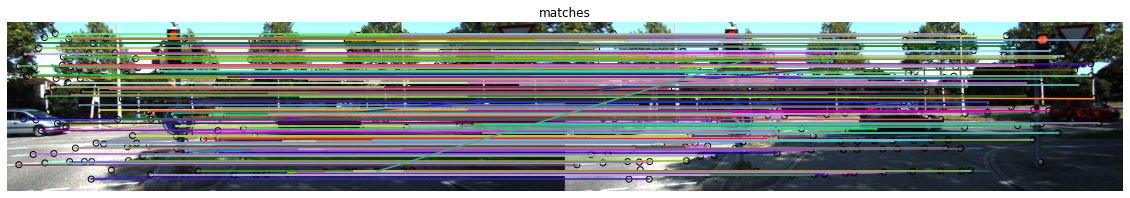

In [3]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL, keypointsR, matchesLR = get_matched_keyppoints(imLgray, imRgray)

fig = plt.figure(2, figsize = (20, 8))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### Step 2: Camera Normalization and Essential Matrix estimation using UFL

Recall that normalization of camera in the two images is given by multiplying the points by $K^{-1}$.


In [4]:
def estimate_ufl (src_pts, dst_pts, K = 100, gamma = 0.01, T = 1e-20) :
    """
    Estimates a homography from src_pts to dst_pts using the UFL method.
    K is the number of initial points to choose from
    """
    assert len(src_pts) == len(dst_pts)
    num_pts = len(src_pts)

    # Initial set of models
    models = []

    # 1. Randomly choose K lines
    for i in range(K) :
        # Randomly choose 8 points
        random_idx = np.random.choice(num_pts, 8, replace=False)
        src_random = src_pts[random_idx]
        dst_random = dst_pts[random_idx]
        # Fit a homography through them
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_random, dst_random) :
            models.append(EMT.params)
            # print(np.diag(np.hstack((dst_random, np.ones((8,1)))) @ EMT.params @ np.vstack((src_random.T, np.ones(8)))))

    # Remove duplicates in the initial set of models
    models = np.unique(np.array(models), axis=0)

    # 2. Nearest model for each point
    nearest_models = np.zeros(num_pts)-1
    # Nearest distances for each point
    distances = np.zeros(num_pts)+np.Inf

    # Homogeneous coordinates
    dst_hom = np.hstack((dst_pts, np.ones((num_pts,1))))
    src_hom = np.vstack((src_pts.T, np.ones(num_pts)))

    # Find nearest model for each point
    for i in range(len(models)) :
        # Distances for each point to the current model
        model_dists = np.diag(dst_hom @ models[i] @ src_hom)
        # Update points where the current model has smaller distance
        nearest_models[np.where((model_dists < distances) & (model_dists < T))] = i
        # Update distances
        distances = np.minimum(distances, model_dists)

    #print(distances)
    #print(nearest_models)

    # 3. The list of resulting models
    result_models = []
    # Match each point to a model index. An index of -1 means outlier.
    pts_to_models = np.zeros(num_pts)-1

    # Readjust parameters for each model to better fit the inliers
    for i in range(len(models)) :
        # The inlier index
        inlier_idx = np.where(nearest_models == i)[0]
        # Skip if no inliers
        if len(inlier_idx) < 8 :
            continue
        # Inlier points
        src_inliers = src_pts[inlier_idx]
        dst_inliers = dst_pts[inlier_idx]
        # Make the model more precise by re-estimating using only the inliers
        EMT = EssentialMatrixTransform()
        if EMT.estimate(src_inliers, dst_inliers) :
            pts_to_models[inlier_idx] = len(result_models)
            result_models.append(EMT.params)

    return result_models, pts_to_models

the number of classes found by ufl is 5
the number of ufl inliers is 186


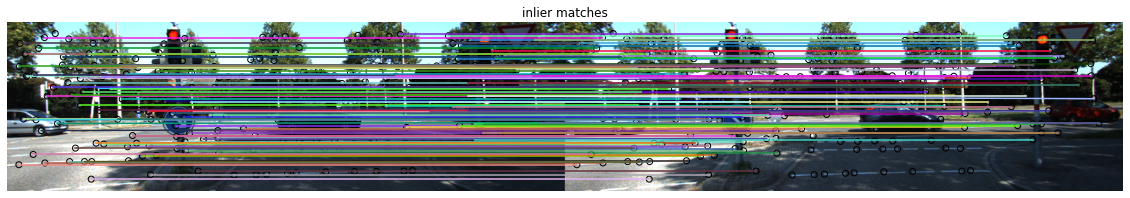

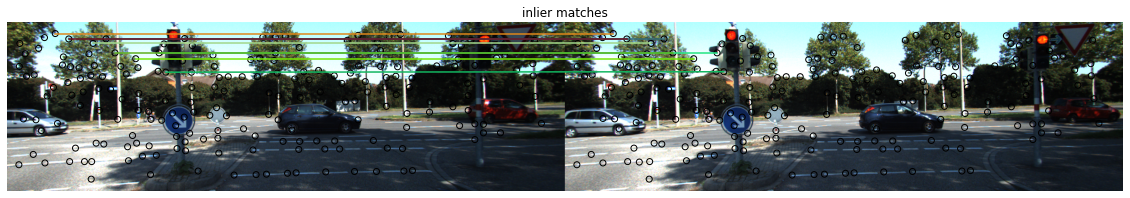

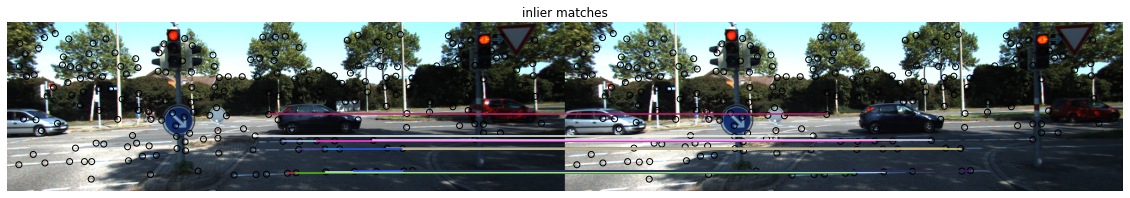

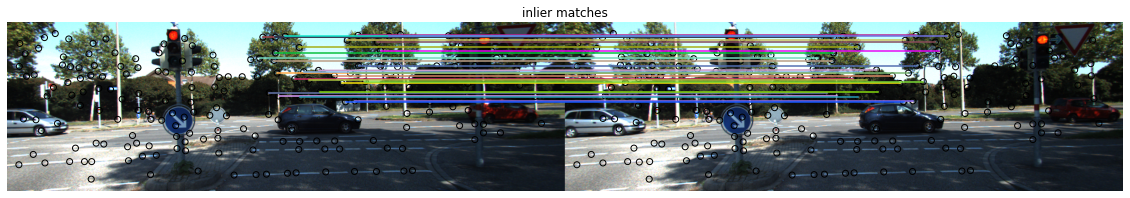

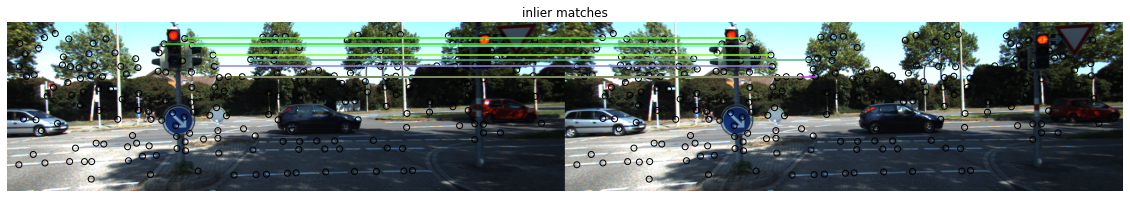

In [5]:
ptsL_inv, ptsR_inv = matchedpoints_to_pairpoints(keypointsL, keypointsR, matchesLR)
# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arra
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL, ptsR = ptsL_inv[:,[1, 0]], ptsR_inv[:,[1, 0]]

n_ptsL = camera_calib_nomalization(ptsL, K)
n_ptsR = camera_calib_nomalization(ptsR, K)

# robustly estimate essential matrices using normalized points and UFL
E_ufl_trans, E_ufl_models = estimate_ufl(n_ptsL, n_ptsR)
num_inliers = len(np.where(E_ufl_models > -1)[0])
num_classes = int(max(E_ufl_models) + 1)
print ('the number of classes found by ufl is {:d}'.format(num_classes))
print ('the number of ufl inliers is {:d}'.format(num_inliers))

# Show the inliers for the different classes
for i in range(num_classes):
    E_i = E_ufl_trans[i]    # Singular values for E
    E_inliers_i = np.where(E_ufl_models == i)[0]

    ind = np.ogrid[:n_ptsL.shape[0]]
    EmatchesRansac = np.column_stack((ind[E_inliers_i],ind[E_inliers_i]))

    fig = plt.figure(5+i,figsize = (20, 8))
    axA = plt.subplot(111)
    axA.set_title("inlier matches")
    plt.gray()
    # NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
    plot_matches(axA, imL, imR, ptsL_inv, ptsR_inv, EmatchesRansac)
    axA.axis('off')
    plt.show()

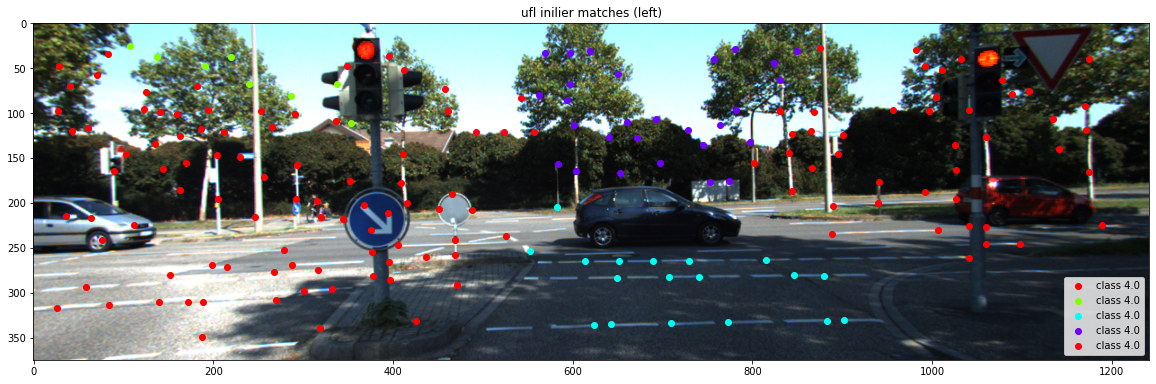

In [7]:
# Maps object points to colours
c_map = plt.cm.get_cmap('hsv', num_classes)

ufl_l_fig = plt.figure(12,figsize = (20, 8))
ufl_l_ax = plt.subplot(111)
ufl_l_ax.set_title("ufl inilier matches (left)")
ufl_l_ax.imshow(imL)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsL[np.where(E_ufl_models == i)]
    ufl_l_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_l_ax.legend()


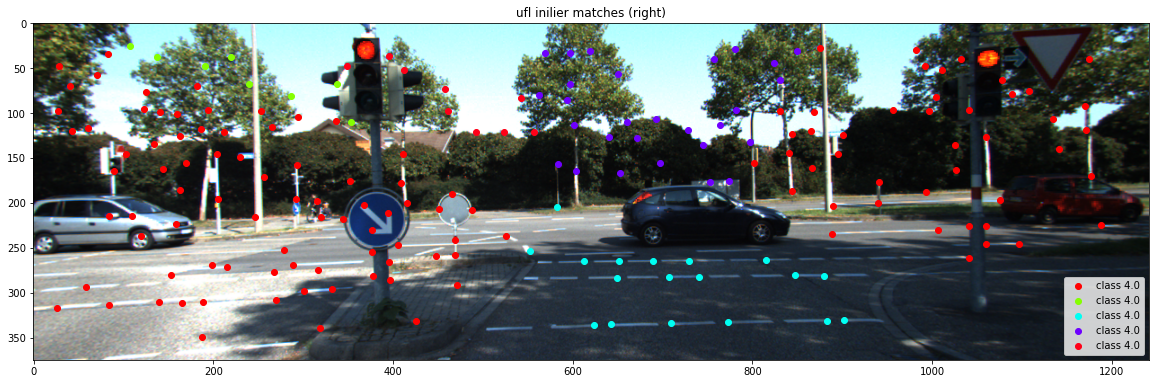

In [8]:
ufl_r_fig = plt.figure(13,figsize = (20, 8))
ufl_r_ax = plt.subplot(111)
ufl_r_ax.set_title("ufl inilier matches (right)")
ufl_r_ax.imshow(imR)

for i in range(num_classes):
    class_colour = c_map(i)
    class_pts = ptsR[np.where(E_ufl_models == i)]
    ufl_r_ax.scatter(x=class_pts[:,0], y=class_pts[:,1], color=class_colour, label=f'class {i}')
    
ufl_r_ax.legend()

### Use the Classes From UFL for Segmentation

## Conclusion


You should include a cell with two-three paragraphs summarizing the conclusions of your project.
